In [1]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.autograd import Variable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Create a random input tensor
# input_tensor = torch.randn(1, 1, 8)  # (batch_size, channels, sequence_length)
input_tensor = torch.tensor([1,2,3,4,1.5]).unsqueeze(0).unsqueeze(0)
# Apply 1D average pooling
pool_size = 2
stride = 2
output_tensor = F.avg_pool1d(input_tensor, kernel_size=input_tensor.shape[-1], stride=1)

print("Input tensor shape:", input_tensor.shape)
print("Output tensor shape:", output_tensor.shape, '   ,   ',output_tensor)

Input tensor shape: torch.Size([1, 1, 5])
Output tensor shape: torch.Size([1, 1, 1])    ,    tensor([[[2.3000]]])


In [5]:
df = pd.read_excel('/content/drive/MyDrive/Data/RawData/US/top50_DowJones.xlsx')
df.head()

,Unnamed: 0,MA,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,CRM,Unnamed: 8,Unnamed: 9,...,Unnamed: 291,Unnamed: 292,Unnamed: 293,Unnamed: 294,ACN,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 300
0,NaN,Open,High,Low,Close,Adj Close,Volume,Open,High,Low,...,Low,Close,Adj Close,Volume,Open,High,Low,Close,Adj Close,Volume
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02 00:00:00,152.009995,153.410004,151.119995,151.910004,147.16893,3168900,102.879997,104.699997,102.269997,...,57.82,58.790001,53.380829,10112800,153.5,154.100006,152.779999,153.839996,141.472977,3061900
3,2018-01-03 00:00:00,152.289993,153.979996,152.160004,153.820007,149.019333,3732400,104.900002,106.139999,104.620003,...,58.310001,58.919998,53.498871,5683700,152.990005,154.990005,152.990005,154.550003,142.125885,2064200
4,2018-01-04 00:00:00,154.539993,157.399994,154.320007,155.809998,150.94725,3247200,106,107.660004,105.769997,...,58.759998,58.82,53.40807,6240000,155,156.860001,154.770004,156.380005,143.808746,1777000


In [6]:
stock_names = [col for col in df.columns if col.split(':')[0] != 'Unnamed']
columns = []
remove_col = []
types = ['_Open'	,'_High'	,'_Low'	,'_Close','_AdjClose','_Volume']
for col in stock_names:
    for type_ in types:
        columns.append(col+type_)
        if type_ == '_Close':
            remove_col.append(col+type_)


In [7]:
df = df.drop(0).drop(1).drop('Unnamed: 0',axis=1)
df.columns = columns
df = df.drop(remove_col,axis=1)
df.head()

,MA_Open,MA_High,MA_Low,MA_AdjClose,MA_Volume,CRM_Open,CRM_High,CRM_Low,CRM_AdjClose,CRM_Volume,...,ABT_Open,ABT_High,ABT_Low,ABT_AdjClose,ABT_Volume,ACN_Open,ACN_High,ACN_Low,ACN_AdjClose,ACN_Volume
2,152.009995,153.410004,151.119995,147.16893,3168900,102.879997,104.699997,102.269997,104.410004,4669200,...,58.200001,59.200001,57.82,53.380829,10112800,153.5,154.100006,152.779999,141.472977,3061900
3,152.289993,153.979996,152.160004,149.019333,3732400,104.900002,106.139999,104.620003,105.290001,3888700,...,58.990002,59.02,58.310001,53.498871,5683700,152.990005,154.990005,152.990005,142.125885,2064200
4,154.539993,157.399994,154.320007,150.94725,3247200,106,107.660004,105.769997,106.68,4540200,...,59.5,59.599998,58.759998,53.40807,6240000,155,156.860001,154.770004,143.808746,1777000
5,156.199997,159.039993,156.190002,154.076416,2747700,107.760002,108.300003,107.199997,108.099998,3368400,...,59.040001,59.09,58.639999,53.562428,5836900,156.610001,157.720001,156.130005,144.995102,1597600
6,158.580002,160.479996,158.080002,154.542145,3143100,108,109.139999,107.57,108.860001,2933600,...,58.849998,58.98,58.529999,53.40807,5411500,157.369995,159.009995,156.839996,146.153763,2616900


In [8]:
df_return = df.pct_change().drop(2)  #WHY 5???
#df_return = df.drop(2)
df_return.head()

,MA_Open,MA_High,MA_Low,MA_AdjClose,MA_Volume,CRM_Open,CRM_High,CRM_Low,CRM_AdjClose,CRM_Volume,...,ABT_Open,ABT_High,ABT_Low,ABT_AdjClose,ABT_Volume,ACN_Open,ACN_High,ACN_Low,ACN_AdjClose,ACN_Volume
3,0.001842,0.003715,0.006882,0.012573,0.177822,0.019635,0.013754,0.022978,0.008428,-0.167159,...,0.013574,-0.003041,0.008475,0.002211,-0.437970,-0.003322,0.005775,0.001375,0.004615,-0.325843
4,0.014774,0.022211,0.014196,0.012937,-0.129997,0.010486,0.014321,0.010992,0.013202,0.167537,...,0.008646,0.009827,0.007717,-0.001697,0.097876,0.013138,0.012065,0.011635,0.011841,-0.139134
5,0.010742,0.010419,0.012118,0.020730,-0.153825,0.016604,0.005945,0.013520,0.013311,-0.258094,...,-0.007731,-0.008557,-0.002042,0.002890,-0.064599,0.010387,0.005483,0.008787,0.008250,-0.100957
6,0.015237,0.009054,0.012101,0.003023,0.143902,0.002227,0.007756,0.003452,0.007031,-0.129082,...,-0.003218,-0.001862,-0.001876,-0.002882,-0.072881,0.004853,0.008179,0.004547,0.007991,0.638020
7,0.006747,-0.002306,0.002910,0.001444,-0.181095,0.009259,0.001832,0.006321,0.002664,0.125682,...,0.004248,0.002035,-0.002563,0.001700,0.379821,0.007181,0.003019,0.003889,0.003335,0.224617


In [9]:
df1 = df_return.iloc[:, :5]
df1.head()

,MA_Open,MA_High,MA_Low,MA_AdjClose,MA_Volume
3,0.001842,0.003715,0.006882,0.012573,0.177822
4,0.014774,0.022211,0.014196,0.012937,-0.129997
5,0.010742,0.010419,0.012118,0.020730,-0.153825
6,0.015237,0.009054,0.012101,0.003023,0.143902
7,0.006747,-0.002306,0.002910,0.001444,-0.181095


In [10]:
df2 = df_return.iloc[:, :4]
df2.head()

,MA_Open,MA_High,MA_Low,MA_AdjClose
3,0.001842,0.003715,0.006882,0.012573
4,0.014774,0.022211,0.014196,0.012937
5,0.010742,0.010419,0.012118,0.020730
6,0.015237,0.009054,0.012101,0.003023
7,0.006747,-0.002306,0.002910,0.001444


In [11]:
# Split the data into input and target sequences
train_input_seq = []
train_target_seq = []
test_input_seq = []
test_target_seq = []

train_input_seq2 = []
train_target_seq2 = []
test_input_seq2 = []
test_target_seq2 = []

seq_length = 8
pred_length = 1
train_test_boundary = int(df1.shape[0]*0.7)


df1 = df1.to_numpy()
df2 = df2.to_numpy()

for i in range(train_test_boundary - seq_length - pred_length):
    train_input_seq.append(df1[i:i+seq_length, :])
    train_target_seq.append(df1[i+seq_length:i+seq_length+pred_length, -2])
    train_input_seq2.append(df2[i:i+seq_length, :])
    train_target_seq2.append(df2[i+seq_length:i+seq_length+pred_length, -1])


for i in range(train_test_boundary - seq_length - pred_length + 10, len(df1) - seq_length - pred_length):
    test_input_seq.append(df1[i:i+seq_length, :])
    test_target_seq.append(df1[i+seq_length:i+seq_length+pred_length, -2])
    test_input_seq2.append(df2[i:i+seq_length, :])
    test_target_seq2.append(df2[i+seq_length:i+seq_length+pred_length, -1])

In [13]:
print(len(train_input_seq2),"   ",len(train_target_seq2),"   ",train_input_seq2[0].shape,"    ",train_target_seq2 [0].shape)

989     989     (8, 4)      (1,)


In [14]:
# Convert data to PyTorch tensors
train_input_seq = torch.tensor(train_input_seq, dtype=torch.float32)
train_target_seq = torch.tensor(train_target_seq, dtype=torch.float32)

<ipython-input-14-cfb3b8451b9b>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_input_seq = torch.tensor(train_input_seq, dtype=torch.float32)


In [15]:
# Convert data to PyTorch tensors
train_input_seq2 = torch.tensor(train_input_seq2, dtype=torch.float32)
train_target_seq2 = torch.tensor(train_target_seq2, dtype=torch.float32)

In [16]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
dataset_train = StockDataset(train_input_seq, train_target_seq)
dataset_test = StockDataset(test_input_seq, test_target_seq)

In [18]:
dataset_train2 = StockDataset(train_input_seq2, train_target_seq2)
dataset_test2 = StockDataset(test_input_seq2, test_target_seq2)

In [19]:
batch_size=16
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [20]:
batch_size=16
train_dataloader2 = DataLoader(dataset_train2, batch_size=batch_size, shuffle=True)
test_dataloader2 = DataLoader(dataset_test2, batch_size=batch_size, shuffle=True)

In [21]:
for batch_idx, (data, targets) in enumerate(train_dataloader):
    print(targets.shape, "  ",data.shape)

torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size([16, 8, 5])
torch.Size([16, 1])    torch.Size(

In [22]:
for batch_idx, (data, targets) in enumerate(train_dataloader2):
    print(targets.shape, "  ",data.shape)

torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size([16, 8, 4])
torch.Size([16, 1])    torch.Size(

In [23]:
import torch.nn as nn

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):

    def __init__(self, n_feats, n_predict):

        super(CNNModel, self).__init__()

        self.cnn1 = nn.Conv1d(in_channels=n_feats, out_channels=64, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.cnn2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.cnn3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.linear = nn.Linear(256, n_predict)

    def forward(self, x):

        x = F.leaky_relu(self.bn1(self.cnn1(x)))
        x = F.leaky_relu(self.bn2(self.cnn2(x)))
        x = F.leaky_relu(self.bn3(self.cnn3(x)))
        x = F.adaptive_avg_pool1d(x, 1) # global average pooling
        x = x.view(-1, 256)
        x = self.linear(x)
        return x


class LSTMModel(nn.Module):

    def __init__(self, n_feats, n_predict, hidden_size=100, num_layers=2):

        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size=n_feats, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, n_predict)

    def forward(self, x):

        # x shape: (batch_size, seq_length, n_feats)

        output, (hidden, cell) = self.lstm(x) # output shape: (batch_size, seq_length, hidden_size)

        output = output[:, -1, :] # output shape: (batch_size, hidden_size)

        output = self.linear(output) # output shape: (batch_size, n_predict)

        return output


In [25]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, dropout):
        super().__init__()

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout),
            num_layers
        )
        self.decoder = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.decoder(x)
        return x

# Input size is now 128 to match hidden size
model2 = Transformer(4, 4, 2, 4, 0.1)

input = torch.rand(16, 8, 4)
output = model2(input)

print(output.shape)
# torch.Size([16, 1])

torch.Size([16, 1])


In [26]:
# Training loop
num_epochs = 100
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
LOSS = []

for epoch in range(num_epochs):
    l = []
    for x_batch, y_batch in tqdm(train_dataloader2):
        # Forward pass
        y_pred = model2(x_batch)

        # Calculate loss
        loss = loss_fn(y_pred, y_batch)
        l.append(loss)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch%5==0):
      print("Epoch ",epoch,"  loss= ",sum(l)/len(l))
    LOSS.append(sum(l)/len(l))

100%|██████████| 62/62 [00:00<00:00, 267.48it/s]


Epoch  0   loss=  tensor(0.0217, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 240.26it/s]


Epoch  5   loss=  tensor(0.0022, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 253.95it/s]


Epoch  10   loss=  tensor(0.0011, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 180.85it/s]


Epoch  15   loss=  tensor(0.0009, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 248.44it/s]


Epoch  20   loss=  tensor(0.0008, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 238.27it/s]


Epoch  25   loss=  tensor(0.0006, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 258.27it/s]


Epoch  30   loss=  tensor(0.0006, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 261.87it/s]


Epoch  35   loss=  tensor(0.0006, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 255.72it/s]


Epoch  40   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 262.25it/s]


Epoch  45   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 243.62it/s]


Epoch  50   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 258.79it/s]


Epoch  55   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 180.97it/s]


Epoch  60   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 175.82it/s]


Epoch  65   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 248.14it/s]


Epoch  70   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 245.73it/s]


Epoch  75   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 251.62it/s]


Epoch  80   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 269.73it/s]


Epoch  85   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 262.77it/s]


Epoch  90   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 259.50it/s]


Epoch  95   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 262.32it/s]


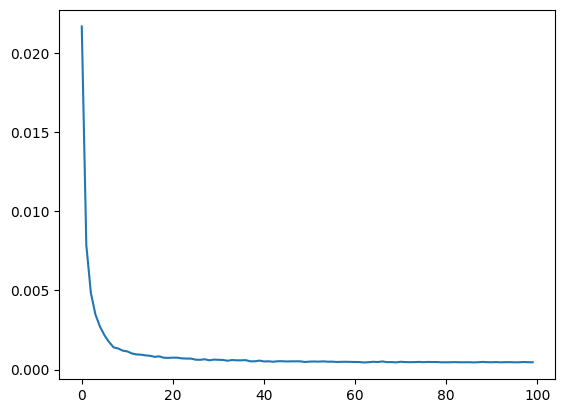

In [27]:
losses= [ loss.detach().numpy() for loss in LOSS]
plt.plot(losses)

In [34]:
n_feats = train_input_seq2.shape[2]
seq_len = train_input_seq2.shape[1]
n_predict = train_target_seq2.shape[1]


model = CNNModel(n_feats=8, n_predict=1)

print(n_feats,"   ",n_predict,"   ",seq_len)

4     1     8


In [35]:
# Training loop
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
LOSS = []

for epoch in range(num_epochs):
    l = []
    for x_batch, y_batch in tqdm(train_dataloader2):
        # Forward pass
        y_pred = model(x_batch)

        # Calculate loss
        loss = loss_fn(y_pred, y_batch)
        l.append(loss)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch%5==0):
      print("Epoch ",epoch,"  loss= ",sum(l)/len(l))
    LOSS.append(sum(l)/len(l))

100%|██████████| 62/62 [00:00<00:00, 201.51it/s]


Epoch  0   loss=  tensor(0.0214, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 233.09it/s]


Epoch  5   loss=  tensor(0.0024, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 240.74it/s]


Epoch  10   loss=  tensor(0.0011, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 243.24it/s]


Epoch  15   loss=  tensor(0.0008, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 192.93it/s]


Epoch  20   loss=  tensor(0.0007, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 199.90it/s]


Epoch  25   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 252.69it/s]


Epoch  30   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 245.36it/s]


Epoch  35   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 260.29it/s]


Epoch  40   loss=  tensor(0.0006, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 263.30it/s]


Epoch  45   loss=  tensor(0.0004, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 244.88it/s]


Epoch  50   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 248.94it/s]


Epoch  55   loss=  tensor(0.0004, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 260.38it/s]


Epoch  60   loss=  tensor(0.0004, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 257.24it/s]


Epoch  65   loss=  tensor(0.0004, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 202.55it/s]


Epoch  70   loss=  tensor(0.0003, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 190.78it/s]


Epoch  75   loss=  tensor(0.0004, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 258.96it/s]


Epoch  80   loss=  tensor(0.0004, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 244.68it/s]


Epoch  85   loss=  tensor(0.0004, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 257.90it/s]


Epoch  90   loss=  tensor(0.0005, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 260.73it/s]


Epoch  95   loss=  tensor(0.0003, grad_fn=<DivBackward0>)


100%|██████████| 62/62 [00:00<00:00, 247.22it/s]


In [175]:
losses= [ loss.detach().numpy() for loss in LOSS]

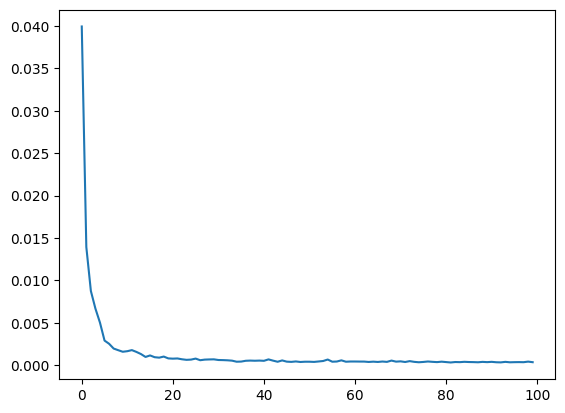

In [176]:
plt.plot(losses)

In [177]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Model parameters
input_size = 8
output_size = 1
batch_size = 16

# Create random input and output data
X = torch.rand(size=(100, input_size, 4))
y = torch.rand(size=(100, output_size))

# Convert to TensorDataset
dataset = TensorDataset(X, y)

# Create DataLoader to generate batches
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Fetch a sample batch
X_batch, y_batch = next(iter(dataloader))

# Model and loss function
model = CNNModel(input_size, output_size)
loss_fn = torch.nn.MSELoss()

# Generate predictions
y_pred = model(X_batch)

# Calculate loss
loss = loss_fn(y_pred, y_batch)

print(X_batch.shape, y_batch.shape)
print(y_pred.shape)
print(loss)

torch.Size([16, 8, 4]) torch.Size([16, 1])
torch.Size([16, 1])
tensor(0.7083, grad_fn=<MseLossBackward0>)


In [181]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

running_loss=0
# for epoch in range(num_epochs):
model.eval()

for batch_idx, (data, targets) in enumerate(tqdm(test_dataloader)):
    # Get data to cuda if possible
    data = data.to(device=device).float()
    targets = targets.to(device=device).float()

    # forward
    scores = torch.Tensor.detach(model(data).squeeze(1)).cpu().numpy()
    targets = torch.Tensor.detach(targets.squeeze(1)).cpu().numpy()

    # print(scores.shape,"************",targets.shape)
    if batch_idx == 0:
        preds = scores
        truth = targets
    else:
        preds = np.concatenate((preds,scores))
        truth = np.concatenate((truth,targets))


    running_loss += loss.item()

<IPython.core.display.Javascript object>

100%|██████████| 27/27 [00:00<00:00, 633.79it/s]


In [29]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

running_loss2=0
# for epoch in range(num_epochs):
model2.eval()

for batch_idx, (data, targets) in enumerate(tqdm(test_dataloader2)):
    # Get data to cuda if possible
    data = data.to(device=device).float()
    targets = targets.to(device=device).float()

    # forward
    scores = torch.Tensor.detach(model2(data).squeeze(1)).cpu().numpy()
    targets = torch.Tensor.detach(targets.squeeze(1)).cpu().numpy()

    # print(scores.shape,"************",targets.shape)
    if batch_idx == 0:
        preds2 = scores
        truth = targets
    else:
        preds2 = np.concatenate((preds2,scores))
        truth = np.concatenate((truth,targets))


    running_loss2 += loss.item()

<IPython.core.display.Javascript object>

100%|██████████| 27/27 [00:00<00:00, 449.48it/s]


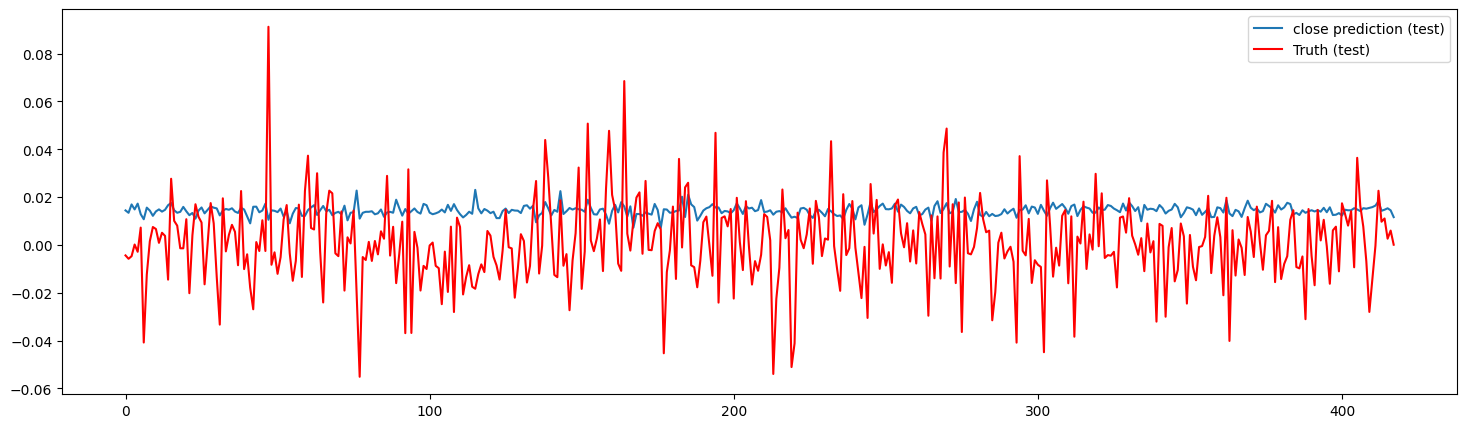

In [32]:
plt.figure(figsize=(18,5))
plt.plot(preds2*10)
plt.plot(truth,color='r')
plt.legend(['close prediction (test)','Truth (test)']);

In [33]:
plt.figure(figsize=(18,5))
plt.plot(preds*10)
plt.plot(truth,color='r')
plt.legend(['close prediction (test)','Truth (test)']);

NameError: ignored

<Figure size 1800x500 with 0 Axes>